In [7]:
import numpy as np
import pylidc as pl
import pandas as pd
import matplotlib.pyplot as plt
from pylidc.utils import consensus
from skimage.measure import find_contours
import os
from scipy.ndimage import gaussian_filter
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats.stats import pearsonr

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks as cf
cf.go_offline(connected=True)
init_notebook_mode(connected=True)


# Analysing medical data to help improve society's quality of life

How can we medical data to help improve society's quality of life?<br>
There is endless types of medical data out there for different diseases, which data should we use in order to help as many people as possible?<br>
In other words, which diseases have the most significant negative impact on society's quality of life as of today?

The ***prevelance*** of the disease alone is not enough to quantify this, take herpes for example. The herpes simplex virus is one of the most common diseases on earth. It is estimated that well over 50% of the world population is infected with the virus. However, most people are completely unaware that they are and show little to no symptoms. There is no cure and once you are infected, the virus will most likely stay in your body for the rest of your life.<br> 
***Conclusion:*** quality of life is only significantly effected if the disease causes pain or limits the patient ablilities.

The most severe effect of a disease is when it causes death, after all, you can't have any "quality of life" anymore if your life has come to an end. <br> 
***Conclusion:*** If we want to have a big impact on society's quality of life it might be interesting to look at the diseases that cause the most deaths.

## Most common causes of death

In [8]:
data=pd.read_csv("annual-number-of-deaths-by-cause.csv" )
print(data.shape)
data.head(5)

(6686, 36)


,Entity,Code,Year,Dementia,Cardiovascular diseases,Kidney disease,Respiratory disease,Liver disease,"Diabetes, blood and endocrine disease",Digestive disease,...,Heat-related deaths (hot or cold exposure),Nutritional deficiencies,Suicide,Execution,Meningitis (deaths),Lower respiratory infections (deaths),Intestinal infectious diseases (deaths),Protein-energy malnutrition (deaths),Conflict (deaths),Terrorism (deaths)
0,Afghanistan,AFG,1990,856.0,28372.0,2708.0,3394.0,1349.0,6177.0,1708.0,...,222.0,567.0,703.0,NaN,6469.977091,22836.912346,295.382207,1607.703797,1508.0,12.0
1,Afghanistan,AFG,1991,908.0,30368.0,2851.0,3641.0,1443.0,6522.0,1792.0,...,230.0,588.0,754.0,NaN,6347.158764,22325.633931,303.866598,1558.132316,3498.0,68.0
2,Afghanistan,AFG,1992,970.0,33035.0,3057.0,3967.0,1572.0,7009.0,1911.0,...,250.0,623.0,820.0,NaN,6659.741428,23205.280750,317.750121,1617.721576,4341.0,49.0
3,Afghanistan,AFG,1993,1066.0,36512.0,3329.0,4398.0,1735.0,7655.0,2071.0,...,289.0,674.0,894.0,NaN,8068.386263,28229.715397,333.978331,1931.808553,NaN,NaN
4,Afghanistan,AFG,1994,1161.0,40285.0,3641.0,4870.0,1911.0,8377.0,2243.0,...,315.0,731.0,977.0,NaN,9432.845127,32652.297630,348.419085,2351.629206,9090.0,22.0


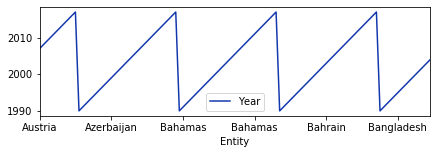

In [9]:
# For each "Entity" the year ranges from 1990 to 2017
data[380:490].plot(x='Entity',y='Year',color='#1337AD', figsize = (7,2))

In [10]:
# One of the entities is "world" which contains the summations over all countries. 
# Let's see which diseases are most prevelent world wide
df = data[data["Entity"]=='World'].iloc[:,2:].sort_values(6572, ascending=False, axis=1)

Text(0.5, 1.0, 'Amount of recorded deaths 1990-2017')

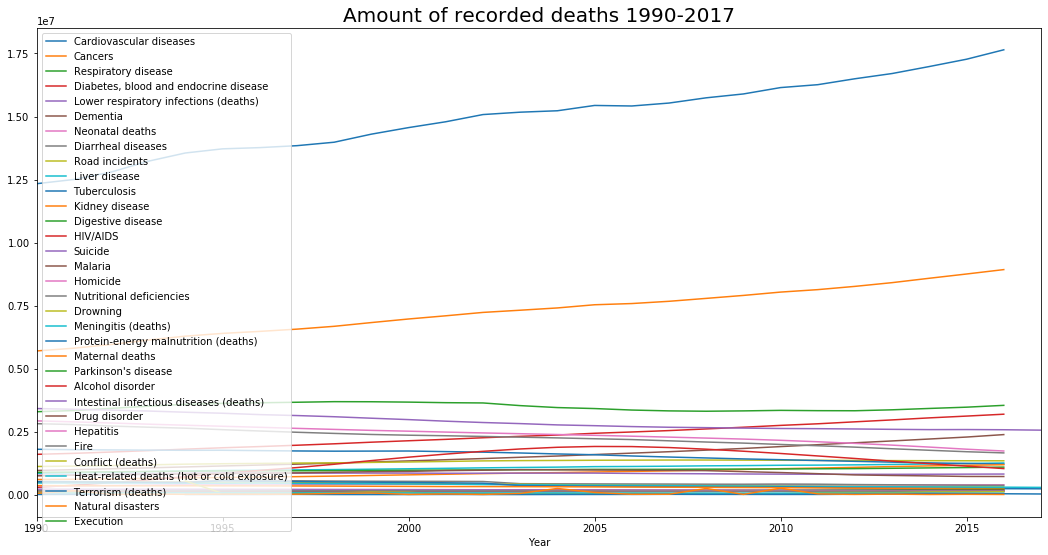

In [11]:
df.plot(x='Year', figsize=(18,9))
plt.title('Amount of recorded deaths 1990-2017', fontsize=20)

It is clear that cardiovascular disease is by far the most common cause of death, followed by cancer, respiratory disease, ... <br> Note that cardiovascular diease is also the faster growing cause of death!

## 3. Globalised view of disease

Lets normalize the datafram to obtain a ratio and not a strict number of death. 

## TODO Find a way to exclude / posibility to exclude world and geographical datas. 

In [12]:
# Copy the df 
normalized = data.copy()

In [13]:
# Check the type of the values, to see if any problems. 
normalized.dtypes

Entity                                         object
Code                                           object
Year                                            int64
Dementia                                      float64
Cardiovascular diseases                       float64
Kidney disease                                float64
Respiratory disease                           float64
Liver disease                                 float64
Diabetes, blood and endocrine disease         float64
Digestive disease                             float64
Hepatitis                                     float64
Cancers                                       float64
Parkinson's disease                           float64
Fire                                          float64
Malaria                                       float64
Drowning                                      float64
Homicide                                      float64
HIV/AIDS                                      float64
Drug disorder               

We see that Execution are not float bu object. Lets remove this column before performing the total

In [15]:
# remove the execution.
normalized = normalized.drop('Execution', 1)

# Take the colums to take into account 
column = normalized.columns.to_list()[3:]

# Compute the total 
normalized['Total'] = normalized[column].sum(axis = 1)


In [16]:
normalized.loc[ :, "Dementia" : "Terrorism (deaths)"] = normalized.loc[ :, "Dementia" : "Terrorism (deaths)"].fillna(0).div(normalized['Total'], axis = 0)



In [17]:
normalized


,Entity,Code,Year,Dementia,Cardiovascular diseases,Kidney disease,Respiratory disease,Liver disease,"Diabetes, blood and endocrine disease",Digestive disease,...,Heat-related deaths (hot or cold exposure),Nutritional deficiencies,Suicide,Meningitis (deaths),Lower respiratory infections (deaths),Intestinal infectious diseases (deaths),Protein-energy malnutrition (deaths),Conflict (deaths),Terrorism (deaths),Total
0,Afghanistan,AFG,1990,0.006708,0.222322,0.021220,0.026595,0.010571,0.048403,0.013384,...,0.001740,0.004443,0.005509,0.050698,0.178949,0.002315,0.012598,0.011817,0.000094,127616.975442
1,Afghanistan,AFG,1991,0.006677,0.223322,0.020966,0.026775,0.010612,0.047962,0.013178,...,0.001691,0.004324,0.005545,0.046676,0.164180,0.002235,0.011458,0.025724,0.000500,135982.791609
2,Afghanistan,AFG,1992,0.006691,0.227871,0.021087,0.027364,0.010843,0.048347,0.013182,...,0.001724,0.004297,0.005656,0.045938,0.160067,0.002192,0.011159,0.029944,0.000338,144972.493876
3,Afghanistan,AFG,1993,0.006752,0.231256,0.021085,0.027856,0.010989,0.048484,0.013117,...,0.001830,0.004269,0.005662,0.051103,0.178798,0.002115,0.012235,0.000000,0.000000,157885.888544
4,Afghanistan,AFG,1994,0.006331,0.219681,0.019855,0.026557,0.010421,0.045681,0.012231,...,0.001718,0.003986,0.005328,0.051439,0.178059,0.001900,0.012824,0.049569,0.000120,183379.191047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6681,Zimbabwe,ZWE,2013,0.009296,0.099218,0.011727,0.021369,0.006827,0.044394,0.021123,...,0.000743,0.019341,0.012804,0.011463,0.082555,0.000158,0.022088,0.000000,0.000006,158781.429228
6682,Zimbabwe,ZWE,2014,0.010014,0.105632,0.012613,0.022560,0.007204,0.048202,0.022462,...,0.000759,0.020977,0.013708,0.011676,0.084711,0.000169,0.022299,0.000000,0.000000,151592.446930
6683,Zimbabwe,ZWE,2015,0.010744,0.110023,0.013356,0.023452,0.007553,0.051376,0.023479,...,0.000882,0.021936,0.014672,0.011913,0.087093,0.000175,0.022494,0.000000,0.000000,145105.777215
6684,Zimbabwe,ZWE,2016,0.011585,0.114236,0.014016,0.024233,0.007862,0.054342,0.024466,...,0.000907,0.023261,0.015569,0.012077,0.088587,0.000183,0.022607,0.000000,0.000000,141050.060551


In [18]:
# Lets intereact with our data to explore it 
@interact
def interact_normalized(year = list(np.append(normalized.Year.unique(),[0])),
                        country = list(np.append(normalized.Entity.unique(),["All"]))):
    norm = normalized
    if country != "All" : 
                        norm = norm[norm['Entity']==country] 
    if year != 0 : 
                        norm = norm[norm['Year']==year] 
            
    return norm

interactive(children=(Dropdown(description='year', options=(1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 19…

We will use Poltly to plot interactive plots as our data vary in term of country and years, it will be easyer like this. 


In [19]:
@interact
def scatter_plot(x=list(normalized.select_dtypes('number').columns), 
                 y=list(normalized.select_dtypes('number').columns)[1:],
                 year = list(np.append(normalized.Year.unique(),[0])),
                 country = list(np.append(normalized.Entity.unique(),["All"])),
                 theme =list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    norm = normalized
    if country != "All" : 
                        norm = norm[norm['Entity']==country] 
    if year != 0 : 
                    norm = norm[norm['Year']==year] 
                
    norm.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
             text='Entity',
             title=f'{y.title()} vs {x.title()}',
            theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('Year', 'Dementia', 'Cardiovascular diseases', 'Kidne…

## Economics

Gather economical data and merge them to the dataset and continue exploration with this dataset (to find links)

In [20]:
economic = pd.read_csv("data/gdp_capita.csv")
economic

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,24985.993281,24713.698045,25025.099563,25533.569780,25796.380251,25239.600411,25630.266492,NaN,NaN,NaN
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773194,59.860874,58.458015,78.706388,82.095231,101.108305,...,591.162346,641.872034,637.165044,613.856333,578.466353,547.228110,556.302139,520.896603,NaN,NaN
2,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4615.468028,5100.095808,5254.882338,5408.410496,4166.979684,3506.072885,4095.812942,3432.385736,NaN,NaN
3,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4437.177794,4247.614342,4413.082887,4578.667934,3952.830781,4124.108543,4532.889198,5253.630064,NaN,NaN
4,Andorra,AND,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,41100.729938,38392.943901,40626.751632,42300.334128,36039.653496,37224.108916,39134.393371,42029.762737,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3736.363217,3600.673475,3876.958302,4054.721339,3574.543333,3697.121677,3948.088150,4281.292329,NaN,NaN
260,"Yemen, Rep.",YEM,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1374.621313,1446.536280,1607.152275,1674.002766,1608.744312,1139.870568,963.494721,944.408499,NaN,NaN
261,South Africa,ZAF,GDP per capita (current US$),NY.GDP.PCAP.CD,443.009816,454.962013,473.011615,511.497253,548.995942,584.704072,...,8007.377412,7501.407280,6829.020465,6428.293579,5730.934174,5272.627749,6127.462297,6374.015446,NaN,NaN
262,Zambia,ZMB,GDP per capita (current US$),NY.GDP.PCAP.CD,232.188867,220.042137,212.578123,213.896441,242.384333,303.281910,...,1672.949830,1763.094184,1878.903489,1763.056239,1332.194321,1280.578447,1534.865371,1539.900158,NaN,NaN


In [21]:
#exploded = economic.explode([economic.columns.to_list()[4: -1]])
exploded = economic.melt(id_vars=economic.columns.to_list()[0: 4], 
        var_name="Year", 
        value_name="GDP").drop(["Indicator Name","Indicator Code" ], 1)

In [22]:
exploded['Year'] = pd.to_numeric(exploded['Year'],errors='coerce')
exploded


,Country Name,Country Code,Year,GDP
0,Aruba,ABW,1960.0,NaN
1,Afghanistan,AFG,1960.0,59.773194
2,Angola,AGO,1960.0,NaN
3,Albania,ALB,1960.0,NaN
4,Andorra,AND,1960.0,NaN
...,...,...,...,...
16099,Kosovo,XKX,NaN,NaN
16100,"Yemen, Rep.",YEM,NaN,NaN
16101,South Africa,ZAF,NaN,NaN
16102,Zambia,ZMB,NaN,NaN


To merge it with our dataframe we need to explode the years

In [23]:
merged = pd.merge(normalized, exploded, how = "inner", left_on = ["Code", "Year"], right_on=["Country Code","Year"])


In [24]:
merged

,Entity,Code,Year,Dementia,Cardiovascular diseases,Kidney disease,Respiratory disease,Liver disease,"Diabetes, blood and endocrine disease",Digestive disease,...,Meningitis (deaths),Lower respiratory infections (deaths),Intestinal infectious diseases (deaths),Protein-energy malnutrition (deaths),Conflict (deaths),Terrorism (deaths),Total,Country Name,Country Code,GDP
0,Afghanistan,AFG,1990,0.006708,0.222322,0.021220,0.026595,0.010571,0.048403,0.013384,...,0.050698,0.178949,0.002315,0.012598,0.011817,0.000094,127616.975442,Afghanistan,AFG,NaN
1,Afghanistan,AFG,1991,0.006677,0.223322,0.020966,0.026775,0.010612,0.047962,0.013178,...,0.046676,0.164180,0.002235,0.011458,0.025724,0.000500,135982.791609,Afghanistan,AFG,NaN
2,Afghanistan,AFG,1992,0.006691,0.227871,0.021087,0.027364,0.010843,0.048347,0.013182,...,0.045938,0.160067,0.002192,0.011159,0.029944,0.000338,144972.493876,Afghanistan,AFG,NaN
3,Afghanistan,AFG,1993,0.006752,0.231256,0.021085,0.027856,0.010989,0.048484,0.013117,...,0.051103,0.178798,0.002115,0.012235,0.000000,0.000000,157885.888544,Afghanistan,AFG,NaN
4,Afghanistan,AFG,1994,0.006331,0.219681,0.019855,0.026557,0.010421,0.045681,0.012231,...,0.051439,0.178059,0.001900,0.012824,0.049569,0.000120,183379.191047,Afghanistan,AFG,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5440,Zimbabwe,ZWE,2013,0.009296,0.099218,0.011727,0.021369,0.006827,0.044394,0.021123,...,0.011463,0.082555,0.000158,0.022088,0.000000,0.000006,158781.429228,Zimbabwe,ZWE,1430.000818
5441,Zimbabwe,ZWE,2014,0.010014,0.105632,0.012613,0.022560,0.007204,0.048202,0.022462,...,0.011676,0.084711,0.000169,0.022299,0.000000,0.000000,151592.446930,Zimbabwe,ZWE,1434.899340
5442,Zimbabwe,ZWE,2015,0.010744,0.110023,0.013356,0.023452,0.007553,0.051376,0.023479,...,0.011913,0.087093,0.000175,0.022494,0.000000,0.000000,145105.777215,Zimbabwe,ZWE,1445.071062
5443,Zimbabwe,ZWE,2016,0.011585,0.114236,0.014016,0.024233,0.007862,0.054342,0.024466,...,0.012077,0.088587,0.000183,0.022607,0.000000,0.000000,141050.060551,Zimbabwe,ZWE,1464.583529


In [25]:
@interact
def scatter_plot(x=list(merged.select_dtypes('number').columns), 
                 y=list(merged.select_dtypes('number').columns)[1:],
                 year = list(np.append(merged.Year.unique(),[0])),
                 country = list(np.append(merged.Entity.unique(),["All"])),
                 theme =list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    norm = merged
    if country != "All" : 
                        norm = norm[norm['Entity']==country] 
    if year != 0 : 
                    norm = norm[norm['Year']==year] 
                
    norm.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
             text='Entity',
             title=f'{y.title()} vs {x.title()}',
            theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('Year', 'Dementia', 'Cardiovascular diseases', 'Kidne…

## Map CV disease vs Cancer ratio

Source: https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

In [27]:
import geopandas as gpd

shapefile = 'data/countries_110m/ne_110m_admin_0_countries.shp'
datafile = 'data/annual-number-of-deaths-by-cause.csv'

gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [28]:
df = pd.read_csv(datafile)

df = df[['Code','Year','Cardiovascular diseases','Cancers']]
df['ratio'] = df['Cardiovascular diseases'] / df['Cancers']
df.head()

,Code,Year,Cardiovascular diseases,Cancers,ratio
0,AFG,1990,28372.0,6483.0,4.376369
1,AFG,1991,30368.0,6912.0,4.393519
2,AFG,1992,33035.0,7495.0,4.407605
3,AFG,1993,36512.0,8218.0,4.442930
4,AFG,1994,40285.0,8978.0,4.487080


In [29]:
df_2016 = df[df['Year'] == 2016]

In [30]:
merged = gdf.merge(df_2016, left_on = 'country_code', right_on = 'Code', how = 'left')
merged.head()

,country,country_code,geometry,Code,Year,Cardiovascular diseases,Cancers,ratio
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI,2016.0,2754.0,791.0,3.481669
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA,2016.0,57112.0,32183.0,1.774601
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,2016.0,81352.0,85102.0,0.955935
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,2016.0,901411.0,685162.0,1.315617


In [31]:
import json

#Read data to json
merged_json = json.loads(merged.to_json())

#Convert to str like object
json_data = json.dumps(merged_json)

In [32]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)

#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][7]

#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 7)

#Define custom tick labels for color bar.
tick_labels = {'0': '0', '1': '1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6','7':'7'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=7,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = 'Ratio of cardiovascular disease to cancer, 2016', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'ratio', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

Loading BokehJS ...

## Change over years

Let's look at how the prevalence and number of deaths of different diseases have changed over the years in different countries.

In [188]:
disease_change = normalized.copy()
disease_change[(disease_change.Year == 2016) | (disease_change.Year == 1990)].head(2)

,Entity,Code,Year,Dementia,Cardiovascular diseases,Kidney disease,Respiratory disease,Liver disease,"Diabetes, blood and endocrine disease",Digestive disease,...,Heat-related deaths (hot or cold exposure),Nutritional deficiencies,Suicide,Meningitis (deaths),Lower respiratory infections (deaths),Intestinal infectious diseases (deaths),Protein-energy malnutrition (deaths),Conflict (deaths),Terrorism (deaths),Total
0,Afghanistan,AFG,1990,0.006708,0.222322,0.021220,0.026595,0.010571,0.048403,0.013384,...,0.001740,0.004443,0.005509,0.050698,0.178949,0.002315,0.012598,0.011817,0.000094,127616.975442
26,Afghanistan,AFG,2016,0.010281,0.284500,0.028502,0.035139,0.014471,0.075834,0.014446,...,0.001583,0.002252,0.007961,0.023632,0.075644,0.001544,0.004831,0.058442,0.021752,282365.961232


In [190]:
normalized.groupby('Entity')['Dementia'].apply(lambda x : x.tail(2).values[0] - x.head(1).values)

Entity
Afghanistan              [0.003573412650598045]
Albania                  [0.016303519050640213]
Algeria                  [0.038048622078948914]
American Samoa          [0.0005728977288687424]
Andean Latin America                      [0.0]
                                 ...           
Yemen                     [0.00695724334563878]
Yugoslavia                                [nan]
Zaire                                     [0.0]
Zambia                   [0.004231526748462256]
Zimbabwe                [0.0033091929644271083]
Name: Dementia, Length: 257, dtype: object

In [223]:
normalized[['Entity', 'Code']].drop_duplicates()

,Entity,Code
0,Afghanistan,AFG
28,Albania,ALB
56,Algeria,DZA
84,American Samoa,ASM
112,Andean Latin America,NaN
...,...,...
6584,Yemen,YEM
6612,Yugoslavia,OWID_YGS
6624,Zaire,NaN
6630,Zambia,ZMB


In [273]:
diseases = normalized.columns.tolist()[3:35]
diseases

diseases_change = normalized[['Entity', 'Code']].drop_duplicates().set_index('Entity')
for disease in diseases:
    diseases_change[disease] = normalized.groupby('Entity')[disease].apply(lambda x : x.tail(2).values[0] - x.head(1).values[0])
    
diseases_change

,Code,Dementia,Cardiovascular diseases,Kidney disease,Respiratory disease,Liver disease,"Diabetes, blood and endocrine disease",Digestive disease,Hepatitis,Cancers,...,Diarrheal diseases,Heat-related deaths (hot or cold exposure),Nutritional deficiencies,Suicide,Meningitis (deaths),Lower respiratory infections (deaths),Intestinal infectious diseases (deaths),Protein-energy malnutrition (deaths),Conflict (deaths),Terrorism (deaths)
Entity,,,,,,,,,,,,,,,,,,,,,
Afghanistan,AFG,0.003573,0.062178,0.007282,0.008544,0.003900,0.027432,0.001062,-0.000392,0.020200,...,-0.014331,-0.000157,-0.002191,0.002453,-0.027066,-0.103305,-0.000771,-0.007767,0.046625,0.021658
Albania,ALB,0.016304,0.152436,0.000710,-0.014659,-0.000646,-0.003366,-0.007147,-0.001649,0.036469,...,-0.005739,-0.000092,-0.002260,0.000103,-0.005691,-0.108082,-0.000006,-0.001947,0.000000,0.000000
Algeria,DZA,0.038049,0.075853,0.015568,0.003399,0.006555,0.042640,0.000103,-0.000953,0.026060,...,-0.009130,-0.000487,-0.001556,0.000764,-0.004584,-0.030440,-0.001498,-0.001899,0.000273,0.000024
American Samoa,ASM,0.000573,-0.027112,0.015784,-0.018775,0.003857,0.074988,-0.005282,0.000000,0.032714,...,-0.006212,0.001286,-0.006212,0.000929,-0.003152,-0.014969,-0.002059,-0.003664,0.000000,0.000000
Andean Latin America,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.013900,0.102244,0.000118,-0.088462,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yemen,YEM,0.006957,0.067893,0.006958,0.003648,0.003503,0.017656,-0.001037,-0.000599,0.032421,...,-0.122561,-0.000608,-0.002358,0.005184,-0.007150,-0.084452,-0.000336,-0.008390,0.144385,0.010013
Yugoslavia,OWID_YGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zaire,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [274]:
diseases_change = diseases_change.dropna(subset=['Cardiovascular diseases'])
diseases_change

,Code,Dementia,Cardiovascular diseases,Kidney disease,Respiratory disease,Liver disease,"Diabetes, blood and endocrine disease",Digestive disease,Hepatitis,Cancers,...,Diarrheal diseases,Heat-related deaths (hot or cold exposure),Nutritional deficiencies,Suicide,Meningitis (deaths),Lower respiratory infections (deaths),Intestinal infectious diseases (deaths),Protein-energy malnutrition (deaths),Conflict (deaths),Terrorism (deaths)
Entity,,,,,,,,,,,,,,,,,,,,,
Afghanistan,AFG,0.003573,0.062178,0.007282,0.008544,0.003900,0.027432,0.001062,-0.000392,0.020200,...,-0.014331,-0.000157,-0.002191,0.002453,-0.027066,-0.103305,-0.000771,-0.007767,0.046625,0.021658
Albania,ALB,0.016304,0.152436,0.000710,-0.014659,-0.000646,-0.003366,-0.007147,-0.001649,0.036469,...,-0.005739,-0.000092,-0.002260,0.000103,-0.005691,-0.108082,-0.000006,-0.001947,0.000000,0.000000
Algeria,DZA,0.038049,0.075853,0.015568,0.003399,0.006555,0.042640,0.000103,-0.000953,0.026060,...,-0.009130,-0.000487,-0.001556,0.000764,-0.004584,-0.030440,-0.001498,-0.001899,0.000273,0.000024
American Samoa,ASM,0.000573,-0.027112,0.015784,-0.018775,0.003857,0.074988,-0.005282,0.000000,0.032714,...,-0.006212,0.001286,-0.006212,0.000929,-0.003152,-0.014969,-0.002059,-0.003664,0.000000,0.000000
Andean Latin America,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.013900,0.102244,0.000118,-0.088462,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
World,OWID_WRL,0.022793,0.049485,0.008582,-0.008640,0.004259,0.023363,0.000276,-0.001155,0.037360,...,-0.033195,-0.000375,-0.004968,-0.002158,-0.005006,-0.029681,-0.002009,-0.007250,0.000141,0.000491
Yemen,YEM,0.006957,0.067893,0.006958,0.003648,0.003503,0.017656,-0.001037,-0.000599,0.032421,...,-0.122561,-0.000608,-0.002358,0.005184,-0.007150,-0.084452,-0.000336,-0.008390,0.144385,0.010013
Zaire,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Visualise this

In [275]:
gdf

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...
172,Republic of Serbia,SRB,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Montenegro,MNE,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,Kosovo,KOS,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,Trinidad and Tobago,TTO,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [276]:
diseases_changed_map = gdf.merge(diseases_change, left_on = 'country_code', right_on = 'Code', how = 'left')
diseases_changed_map

,country,country_code,geometry,Code,Dementia,Cardiovascular diseases,Kidney disease,Respiratory disease,Liver disease,"Diabetes, blood and endocrine disease",...,Diarrheal diseases,Heat-related deaths (hot or cold exposure),Nutritional deficiencies,Suicide,Meningitis (deaths),Lower respiratory infections (deaths),Intestinal infectious diseases (deaths),Protein-energy malnutrition (deaths),Conflict (deaths),Terrorism (deaths)
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI,0.002667,-0.031845,0.014734,-0.020072,0.000226,0.130725,...,-0.011163,-0.000427,-0.001375,-0.005664,-0.004895,-0.025378,-2.380433e-03,-0.001792,0.0,0.000000
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA,0.007784,0.062765,0.003327,0.006848,0.004821,0.015746,...,-0.057313,0.000001,-0.022384,0.003645,-0.003430,-0.054579,-4.617705e-04,-0.014273,0.0,0.000008
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,0.033785,-0.095153,0.007274,0.009861,0.001475,0.018702,...,0.005310,-0.000253,0.000022,-0.003720,-0.000396,0.002820,-1.786743e-06,0.000475,0.0,0.000004
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,0.032087,-0.093188,0.014453,0.021509,0.005991,0.022978,...,0.003044,-0.000229,-0.000050,0.000651,-0.000796,0.001315,-3.837466e-06,0.000817,0.0,0.000022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Republic of Serbia,SRB,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",SRB,0.013942,-0.025947,0.004889,-0.000128,-0.001560,0.011225,...,-0.000048,-0.000332,0.000025,-0.006027,-0.000967,0.000197,-5.640485e-06,0.000009,0.0,0.000000
173,Montenegro,MNE,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",MNE,0.004799,0.013651,0.001979,-0.000183,-0.000254,0.005247,...,-0.000301,-0.000067,-0.000067,-0.001013,-0.000540,-0.003500,-3.563223e-06,-0.000033,0.0,0.000000
174,Kosovo,KOS,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,Trinidad and Tobago,TTO,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",TTO,0.010015,-0.043946,0.013385,-0.004421,0.000717,0.049585,...,-0.003968,-0.000198,-0.003983,-0.002133,-0.002555,-0.011385,-2.195436e-07,-0.002625,0.0,0.000000


In [277]:
#Read data to json
diseases_changed_map_json = json.loads(diseases_changed_map.to_json())

#Convert to str like object
diseases_changed_map_json_data = json.dumps(diseases_changed_map_json)

In [280]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = diseases_changed_map_json_data)

#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]

#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 0.2)

#Define custom tick labels for color bar.
#tick_labels = {'0': '0', '1': '1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6','7':'7'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=7,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = 'Change between 1990 and 2016 in cardiovascular diseases', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Cardiovascular diseases', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

Loading BokehJS ...